In [788]:
%pylab inline
import re,os
n=18
max_l=4
in_root = '/mnt/store1/oliverphilcox/GRFs_per_dense/SE_out/grf'
rand_it = 12

Populating the interactive namespace from numpy and matplotlib


In [789]:
def reader(in_str):
    file_name = in_root+'.'+in_str+'.out'

    dat = np.zeros([n,n,max_l+1])

    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Multipole",line):
                    start=True
                continue
            if re.match("Multipole",line):
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Saving',line):
                start=False
                continue
            x=line.split()
            b1=int(x[0])
            b2=int(x[1])
            dat[b1,b2,0]=float(x[2])/2.
            if b1!=b2:
                dat[b2,b1,0]=float(x[2])/2.
            for ell in range(1,max_l+1):
                dat[b1,b2,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
                if b1!=b2:
                    dat[b2,b1,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
    return dat;

In [790]:
rrr=reader('0.rrr')

all_zeta = []

for mock_no in range(100):
    
    if not os.path.exists(in_root+'.%d.nnn_%d.out'%(mock_no,rand_it-1)):
        continue;

    all_n=[]
    for i in range(rand_it):
        all_n.append(reader('%d.nnn_%d'%(mock_no,i)))

    this_nnn = np.mean(all_n,axis=0)
    
    this_zeta = this_nnn/rrr[:,:,0].reshape(n,n,1)
    
    all_zeta.append(this_zeta)
    
all_zeta = np.asarray(all_zeta)
n_mocks = len(all_zeta)
print("N_mocks = %d"%n_mocks)

N_mocks = 100


In [791]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks,n-min_r_bin,max_l+1])

for i in range(n_mocks):
    denom = np.zeros([n-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]

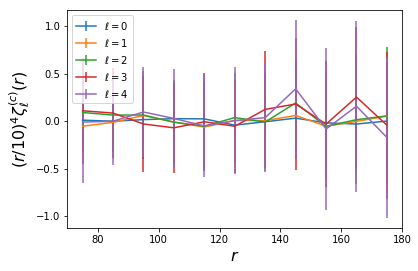

In [792]:
for ell in range(max_l+1):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10)**4*zeta_compress.mean(axis=0)[:,ell],
                 (r_bins[min_r_bin:]/10.)**4*zeta_compress.std(axis=0)[:,ell],label=r'$\ell=%d$'%ell)
plt.legend();
plt.ylabel(r'$(r/10)^4\zeta^{(c)}_\ell(r)$',fontsize=16);
plt.xlabel(r'$r$',fontsize=16);

In [793]:
zeta_compress_flat=[]
for i in range(n_mocks):
    zeta_compress_flat.append(zeta_compress[i].T.ravel())
zeta_compress_flat=np.asarray(zeta_compress_flat)

cov_zeta = np.cov(zeta_compress_flat.T)

In [794]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

## Load theory:

In [852]:
theory = np.load('/mnt/store1/oliverphilcox/GRFs_per_dense/compressed_theory_cov.npz')
c_theory = theory['c_tot']#*1.5**3
c3=theory['c3']
c4=theory['c4']
c5=theory['c5']
c6=theory['c6']
c_theory=c3+c4/10+c5/100+c6/1000

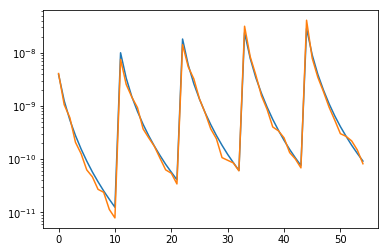

In [853]:
plt.plot(np.diag(c_theory))
#plt.plot(np.diag(c4))
plt.plot(np.diag(cov_zeta))
plt.yscale('log')

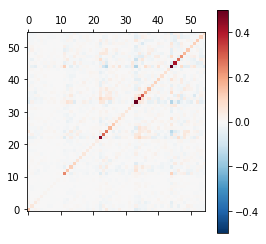

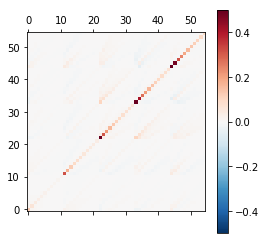

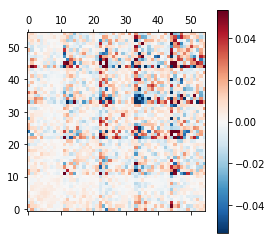

In [854]:
plotter(cov_zeta*theory['r_mat'],vmax=0.5)
plotter(c_theory*theory['r_mat'],vmax=0.5)
plotter((c_theory-cov_zeta)*theory['r_mat'])

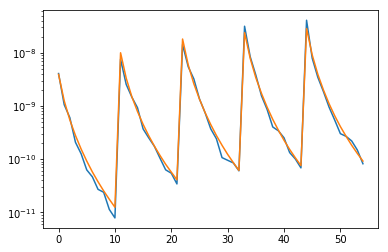

In [855]:
plt.plot(np.diag(cov_zeta))
plt.plot(np.diag(c_theory))
plt.yscale('log')

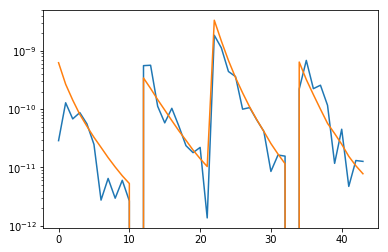

In [856]:
plt.plot(np.diag(cov_zeta[:,11:]))
plt.plot(np.diag(c_theory[:,11:]))
plt.yscale('log');

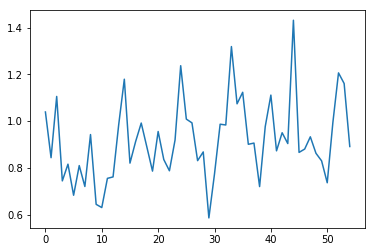

In [857]:
plt.plot(np.diag(cov_zeta/c_theory))

In [858]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

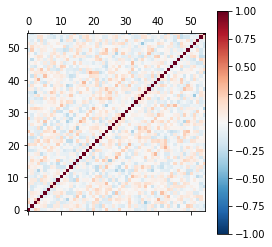

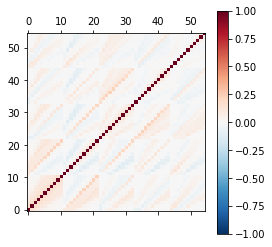

In [859]:
plotter(reduce(cov_zeta))
plotter(reduce(c_theory))

In [860]:
D_mat = (len(cov_zeta)+1.)/(n_mocks-1.)
prec_theory=np.linalg.inv(c_theory)
prec_obs = np.linalg.inv(cov_zeta)*(1.-D_mat)

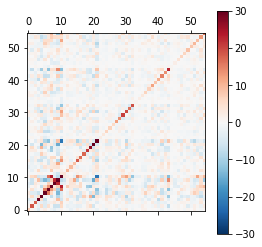

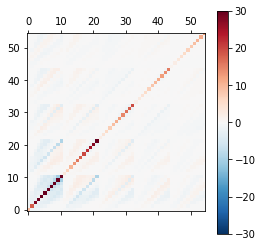

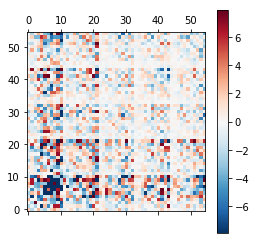

In [861]:
plotter(prec_obs/theory['r_mat'],vmax=30)
plotter(prec_theory/theory['r_mat'],vmax=30)
plotter((prec_theory-prec_obs)/theory['r_mat'])

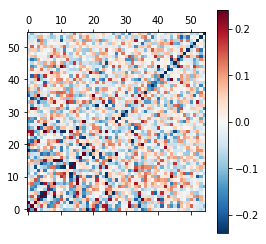

In [862]:
chol = np.linalg.cholesky(cov_zeta)
disc = np.matmul(chol.T,np.matmul(prec_theory,chol))-np.eye(len(prec_theory))
plotter(disc)